
# Exoplanet Classification


## 1. Introduction

In this repository we compare multiple machine learning algorithms for binary classification.

The methods will be tested on the task of binary classification of exoplanet candidates found by NASA’s Kepler spacecraft, found [here](https://exoplanetarchive.ipac.caltech.edu).

An exoplanet is a planet outside of the solar system (i.e. does not orbit
the sun). The spacecraft first identifies possible signs of exoplanets, referred to as Kepler Object
of Interest (KOI). Not all KOIs are actual exoplanets however, some are false positives of different
natures. The task performed is to classify KOIs between confirmed exoplanets and false positives. Each
observation corresponds to a KOI and the features are estimates of the physical properties of the
(possible) exoplanet (radius, temperature, features of the host star, etc).

## 2. Imports and Input Reading

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn import svm
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,precision_score,recall_score



In [2]:
warnings.simplefilter("ignore")
sns.set(rc={'figure.figsize':(10,10)})

Reading the dataset

In [3]:
df = pd.read_csv("koi_data.csv")
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


## Pre-processing

Changing categoric data to discrete values

In [4]:
# koi_disposition column is now 1 if it's confirmed or 0 otherwise
data = df.copy()
data["koi_disposition"] = df["koi_disposition"].apply(lambda x: 1 if (x=='CONFIRMED') else 0)

data.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,1,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,1,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,0,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,1,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,0,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [5]:
# changing kepoi_name to numeric values
data["kepoi_name"] = data.index
data.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,0,1,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,1,1,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,2,0,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,3,1,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,4,0,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [7]:
data.columns

Index(['kepoi_name', 'koi_disposition', 'koi_period', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_kepmag',
       'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag',
       'koi_kmag', 'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec',
       'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco',
       'koi_dicco_mra', 'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra',
       'koi_dikco_mdec', 'koi_dikco_msky'],
      dtype='object')

Feature Selection

In [8]:
# feature selection
TARGET = "koi_disposition"
NAME = "kepoi_name"
N_FEATURES = len(data.columns) - 2 

features = list(data.columns)
features.remove(TARGET)
features.remove(NAME) #removes name from features list

skb = feature_selection.SelectKBest(feature_selection.f_classif)
skb = skb.fit(data[features], data[TARGET])


## Data Normalization

In [9]:
data[features] = data[features] - data[features].mean()
data[features] = data[features]/data[features].std()
data["kepoi_name"] = df.index # returning to original index

## Train/Test Split and Model Evaluation

In [10]:
# method performs k-fold cross validation and returns train/test accuracy, 
# precision and recall
index = data["kepoi_name"]
k = 5
def model_eval(model,data):
    results = []
    kfold = KFold(n_splits = k)
    for train_index,test_index in kfold.split(index):
        # train/test split
        x_train = skb.transform(data.loc[train_index, features])
        y_train = (data.loc[train_index, TARGET])
        x_test = skb.transform(data.loc[test_index, features])
        y_test = (data.loc[test_index, TARGET])
        model.fit(x_train,y_train)
        # precision, recall and accuracy       
        pred = model.predict(x_test)
        acc = accuracy_score(y_test,pred)
        train_acc = model.score(x_train,y_train)
        precision = precision_score(y_test,pred) 
        recall = recall_score(y_test,pred)

        results.append([acc,train_acc,precision,recall])
    # using a dataframe to sotre informations and return k-fold metrics
    df_results = pd.DataFrame(results,columns=["acc","train_acc","precision","recall"]) #dataframe que contem todas as acuracias e erri de treino
    return df_results["acc"].mean(),df_results["train_acc"].mean(), df_results["precision"].mean(), df_results["recall"].mean()
        
        


  ## Graphs

In [11]:
def graph_plot(df,title):
    plt.plot(df["model_index"], df['acc'],label='acc')
    plt.plot(df["model_index"], df["train_acc"],label='acc de treino')
    plt.title(title)
    plt.axhline(c="r",y=naive_acc,label='Naive Bayes')
    plt.legend()
    plt.show()

In [ ]:
graph_plot()

  ## Best Models
  
We create a dataframe to store the best models' results

In [33]:
col = ["acc","train_acc","parameters","param_value","precision","recall"]
best_index = ["naive_bayes","decision_tree","svm","knn","random_forest","gt_boosting"]
best_models = pd.DataFrame(columns=col,index=best_index)


In [34]:
# Append to best models dataframe
def add_to_best_models(row,bm_acc,bm_train_acc,bm_prec,bm_recall,bm_param=None,bm_param_val=None):
    best_models.loc[row]["acc"] = bm_acc
    best_models.loc[row]["train_acc"] = bm_train_acc
    best_models.loc[row]["parameters"] = bm_param
    best_models.loc[row]["param_value"] = bm_param_val
    best_models.loc[row]["precision"] = bm_prec
    best_models.loc[row]["recall"] = bm_recall

  ##  8. Experimental Model Evaluation

We'll compare the following machine learning algorithms:
1. Naive Bayes
2. Decision Tree 
3. SVM
4. K-NN
5. Random Forest
6. Gradient Tree Boosting



#### 8.1. Naive Bayes

We'll use Naive Bayes as a experimental baseline

In [35]:
gnb = GaussianNB()
naive_acc, naive_train_acc, precision, recall = model_eval(gnb,data)

# We only create one NB model, so it is our best one
add_to_best_models("naive_bayes",naive_acc,naive_train_acc,precision,recall)

aux_nb = best_models.loc["naive_bayes"][["acc","train_acc","precision","recall"]]
aux_nb

acc          0.916176
train_acc    0.916858
precision    0.675045
recall       0.862582
Name: naive_bayes, dtype: object

Naive Bayes is an non-parametric algorithm that assumes feature indenpendence. We'll use the results from this algorithm as a baseline to compare to all the other methods. This algorithm achieved high accuracy, which indicates that we're dealing with simple data and independent features.

#### 8.2. Decision Tree

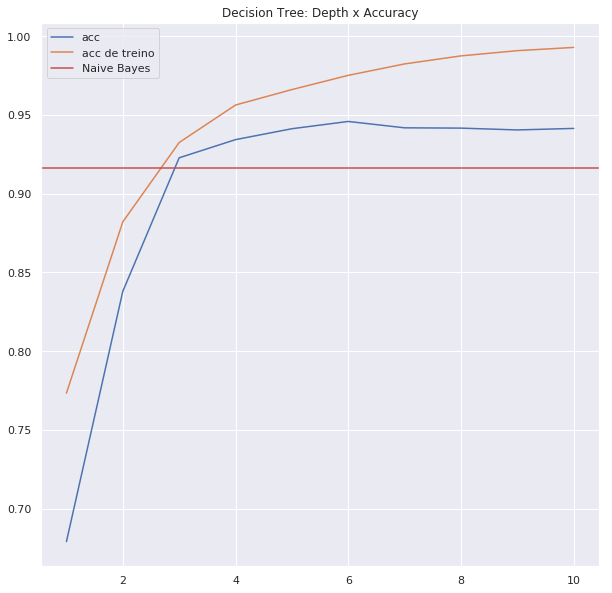

In [36]:
results = []
# testing with unlimited tree depth
dec_tree = tree.DecisionTreeClassifier(max_depth=None)
acc, train_acc, precision, recall = model_eval(dec_tree,data)
results.append([acc, train_acc])

dec_tree = 11
aux_acc = 0
aux_train_acc = 0
aux_max_depth = 0
aux_precision = 0
aux_recall = 0

for max_depth in range(1,dec_tree):
    dec_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    acc, train_acc, precision,recall = model_eval(dec_tree,data)
#   selecting the best model
    if acc > aux_acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_max_depth = max_depth
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,max_depth])
    
add_to_best_models("decision_tree",aux_acc,aux_train_acc,precision,recall,"max_depth",aux_max_depth)


df_dt = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Decision Tree: Depth x Accuracy"
graph_plot(df_dt,title)


For the decision tree, we alter it's max depth. With depths below 8, the models start to overfit. Trees with unlimited depth or with depth below 3, the algorithm overfits and doesn't outperform the Naive Bayes baseline. obtido com o Naive Bayes.

#### 8.3. SVM

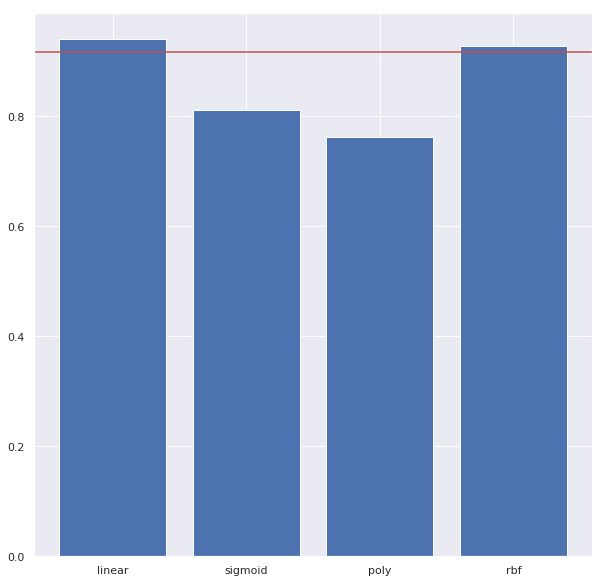

In [37]:
kernel_list = ["linear","sigmoid","poly","rbf"]
results = []
c = 1
aux_acc = 0
aux_train_acc = 0
aux_kernel = ''
aux_precision = 0
aux_recall = 0

for kernel in kernel_list:
    svm_classifier = svm.SVC(c,kernel,gamma='auto',probability=True)
    acc, train_acc, precision, recall = model_eval(svm_classifier, data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_kernel = kernel
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc])
df_svm = pd.DataFrame(results,columns=["acc","train_acc"])

add_to_best_models("svm",aux_acc,aux_train_acc,aux_precision,aux_recall,"kernel",aux_kernel)

# SVM creates a graph barm so we don't use  the graph plot method
plt.bar(kernel_list,df_svm["acc"])
plt.axhline(naive_acc,c="r")
plt.show()

For the SVM, we compare different kernels. Only two of the kernels used outperform our baseline. Of all kernels, the best result was achieved while using the linear kernel, which indicates that the data is almost linearly separable, thus we don't need to alter the data representation.

#### 8.4. K-NN

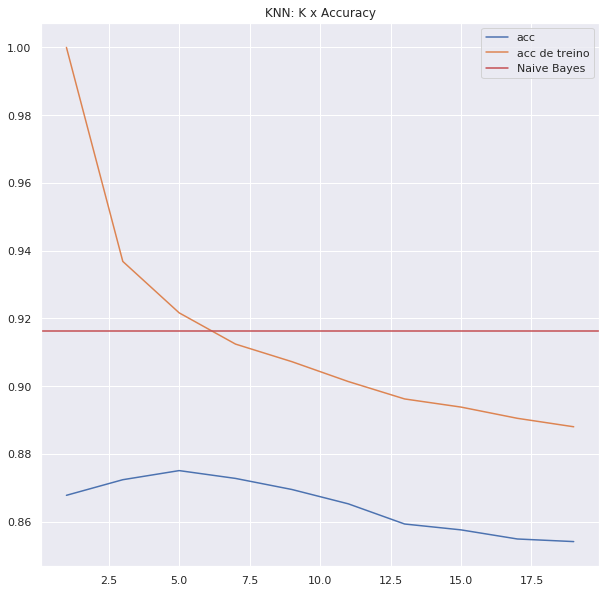

In [38]:
results = []
aux_acc = 0
aux_train_acc = 0
aux_k = 0
knn_range = 20
aux_precision = 0
aux_recall = 0

for i in range(1,knn_range,2):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    acc, train_acc, precision, recall = model_eval(knn,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_k = i
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,i])

df_knn = pd.DataFrame(results, columns=["acc","train_acc","model_index"])

add_to_best_models("knn",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_neighbors",aux_k)

title="KNN: K x Accuracy"
graph_plot(df_knn,title)

Here we vary the the number of neighbors (k) used to group data. If we use too big a K, the model overfits.

#### 8.5. Random Forest

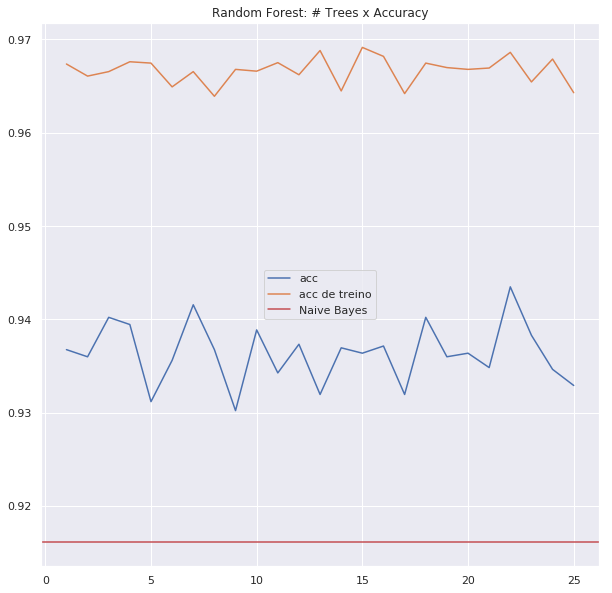

In [39]:
N = 25
max_depth = 5
results = []
aux_acc = 0
aux_train_acc = 0
aux_precision = 0
aux_recall = 0

aux_N = 0
for n in range(1,N+1):
    random_forest = ensemble.RandomForestClassifier(n_estimators=N, max_depth=max_depth)
    acc, train_acc, precision, recall = model_eval(random_forest,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_N = n
        aux_precision = precision
        aux_recall = recall
    results.append([acc,train_acc,n])


add_to_best_models("random_forest",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_estimators",aux_N)

df_rf = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Random Forest: # Trees x Accuracy"
graph_plot(df_rf,title)


Here we vary the number of forests that each model will use. Furthermore, we fix the depth of each tree to 5. Random Forest is a bagging-based algorithm, so it is less prone to overfit, given it uses samples from the dataset in order to avoid variance problems. All models created outperform our baseline and achieve accuracies between 0.93 and 0.94, with no tendency to drop.


#### 8.6. Gradient Tree Boosting

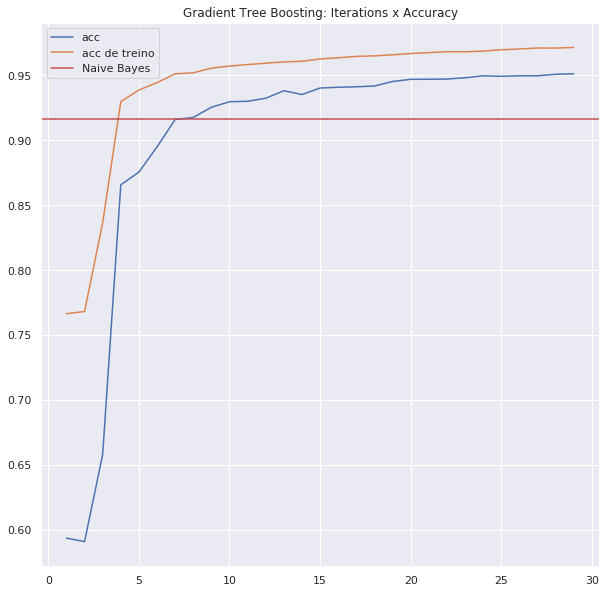

In [40]:
results = []
gtb_range = 30
aux_acc = 0
aux_train_acc = 0
aux_estimators = 0
aux_precision = 0
aux_recall = 0
for n_estimators in range(1,gtb_range):
    gt_boosting = ensemble.GradientBoostingClassifier(n_estimators=n_estimators)
    acc, train_acc, precision,recall = model_eval(gt_boosting,data)
    if aux_acc < acc:
        aux_acc = acc
        aux_train_acc = train_acc
        aux_estimators = n_estimators
        aux_recall = recall
        aux_precision = precision
    results.append([acc,train_acc,n_estimators])

add_to_best_models("gt_boosting",aux_acc,aux_train_acc,aux_precision,aux_recall,"n_estimators",aux_estimators)

df_gtb = pd.DataFrame(results,columns=["acc","train_acc","model_index"])
title = "Gradient Tree Boosting: Iterations x Accuracy"
graph_plot(df_gtb,title)


For the Gradient Tree Boosting algorithm, we vary the number of iterations used by each model. This is a boosting-based algorithm, so it uses multiple weak models to create a strong, robust to overfit one. This can be observed in the graph above, where the accuracy increases as we use more iterations.

   ## <p style="text-align: center;">  9. Results </p>  

### 9.1 Comparative Evaluation

Now, we have a dataframe with information from the best models (for each algorithm) created throughout this notebook

In [41]:
best_models

,acc,train_acc,parameters,param_value,precision,recall
naive_bayes,0.916176,0.916858,None,None,0.675045,0.862582
decision_tree,0.94579,0.975058,max_depth,6,0.743914,0.929921
svm,0.941175,0.955738,kernel,linear,0.736817,0.947416
knn,0.875033,0.921617,n_neighbors,5,0.630387,0.952035
random_forest,0.943482,0.968618,n_estimators,22,0.743326,0.853466
gt_boosting,0.951175,0.971501,n_estimators,29,0.74863,0.850337


The graph below summarizes the dataframe above

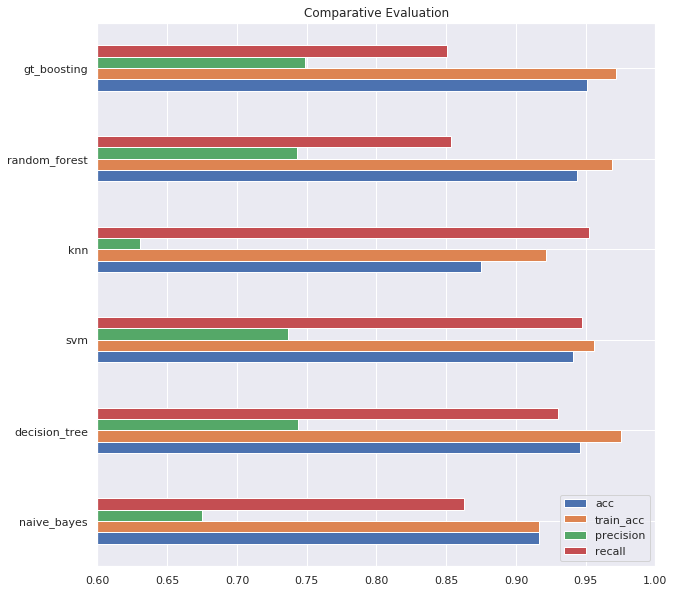

In [42]:
best_models.plot.barh(y=['acc','train_acc',"precision","recall"], 
             xlim=(0.6,1.0),
             title='Comparative Evaluation')
plt.show()

**Naive bayes**: Low precision but good recall, given the algorithm's low complexity and size of the dataset. However, outperforms all KNN models created.

**Decision Tree**: Outperforms Naive Bayes, with significant increases in accuracy and precision, but with similar recall.

**SVM**: One of the most complex and robust algorithms used in this notebook. Achieved the second best recall of all models, but average precision, which can indicate that the margin used is too wide, resulting in more false positives than expected.

**KNN**: The worst model created, did not pass our baseline. Can be explained by the specificity of the data set. Achieved the biggest recall of all models, but low precision, even lower than Naive Baiyes's

**Random Forest**: An improvment of the Decision Tree algorithm. Achieves better accuracy than the Decision Tree.

**Gradient Tree Boosting**: Second worst recall, but the overall best accuracy.

### 9.2 ROC curve

Here we instantiate models with the optimal parameters for each algorithm

In [43]:
C=1
N=5
nb = GaussianNB()
svm_classifier = svm.SVC(C,kernel=best_models.loc["svm"]["param_value"],gamma='auto',probability=True)
decision_tree = tree.DecisionTreeClassifier(max_depth=int(best_models.loc["decision_tree"]["param_value"]))
knn = neighbors.KNeighborsClassifier(n_neighbors=int(best_models.loc["knn"]["param_value"]))
random_forest = ensemble.RandomForestClassifier(n_estimators=N, max_depth=int(best_models.loc["random_forest"]["param_value"]))
gt_boosting = ensemble.GradientBoostingClassifier(n_estimators=int(best_models.loc["gt_boosting"]["param_value"]))

# list to iter through all models
models = [nb, svm_classifier, decision_tree, knn, random_forest, gt_boosting]


Method to plot the ROC curve for each model

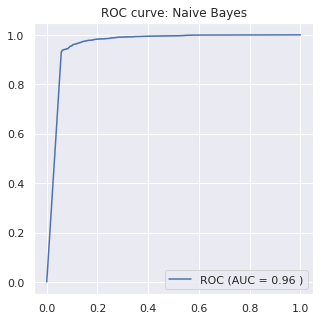

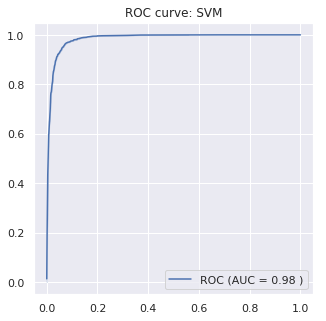

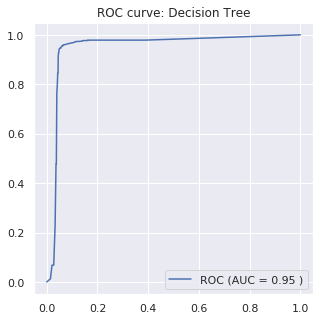

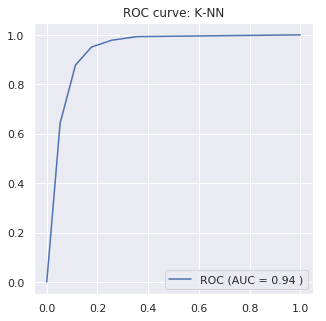

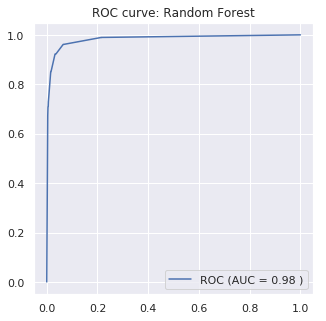

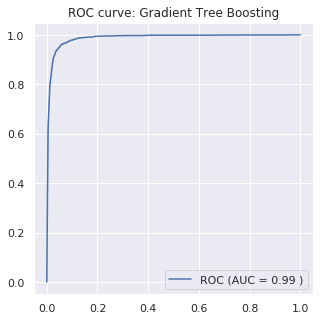

In [44]:
sns.set(rc={'figure.figsize':(5,5)}) # resetando o tamanho dos graficos, visto que sao 6 em seguida

# This list helps to plt the method`s name
methods_names = ["Naive Bayes","SVM","Decision Tree","K-NN","Random Forest","Gradient Tree Boosting"]

def plot_roc(model, title):
    all_probs = []
    all_y_test = []
    index = data["kepoi_name"]
    k=5
    kfold = KFold(n_splits = k)
    for train_index,test_index in kfold.split(index):
        x_train = skb.transform(data.loc[train_index, features])
        y_train = (data.loc[train_index, TARGET])

        x_test = skb.transform(data.loc[test_index, features])
        y_test = (data.loc[test_index, TARGET])
        model.fit(x_train,y_train)

        pred = model.predict(x_test).tolist()
        probs = model.predict_proba(x_test)[:,1].tolist()
        all_probs += probs
        all_y_test += y_test.values.tolist()
    fpr, tpr, thresholds = roc_curve(all_y_test, all_probs)
    sns.lineplot(fpr,tpr,label="ROC (AUC = %0.2f )" %(round(auc(fpr,tpr), 4)))    
    plt.title(title)
    plt.show()
    

for j in range(len(models)):
    plot_roc(models[j], "ROC curve: " + methods_names[j])
